# MNIST 손글씨 - CNN v2
- 2 x Conv2D layers
- 1 MaxPooling2D layer
- 1 FCN layer
- 1 Output layer

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

- 데이터 전처리

In [3]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
# X_train, X_test 정규화(0 ~ 1), 이미지 차원 변경: 2차원 --> 3차원
X_train = X_train.reshape(-1, 28, 28, 1) / 255.
X_test = X_test.reshape(-1, 28, 28, 1) / 255.
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [5]:
# One hot encoding
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_train.shape, Y_test.shape

((60000, 10), (10000, 10))

- 모델 정의/설정/학습/평가

In [6]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [7]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 1), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),                                 # MaxPooling2D(pool_size=(2, 2))
    Flatten(),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4719104   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 4,743,050
Trainable params: 4,743,050
Non-trainable params: 0
______________________________________________

In [8]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

In [9]:
model_path = 'best-mnist-cnn-v2.h5py'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10)

In [10]:
with tf.device("/device:GPU:0"):
    hist = model.fit(
        X_train, Y_train, validation_split=0.2, epochs=100, batch_size=200,
        callbacks=[mc, es]
    )

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
47800/48000 [============================>.] - ETA: 0s - loss: 0.1839 - accuracy: 0.9449
Epoch 00001: val_loss improved from inf to 0.05690, saving model to best-mnist-cnn-v2.h5py
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: best-mnist-cnn-v2.h5py\assets
48000/48000 [==============================] - 43s 905us/sample - loss: 0.1834 - accuracy: 0.9451 - val_loss: 0.0569 - val_accuracy: 0.9818
Epoch 2/100
47800/48000 [============================>.] - ETA: 0s - loss: 0.0451 - accuracy: 0.9858
Epoch 00002: val_loss improved from 0.05690 to 0.04603, saving model to best-mnist-cnn-v2.h5py
INFO:tensorflow:Assets written to: best-mnist-cnn-v2.h5py\assets
48000/48000 [==============================] - 44s 909us/sample - loss: 0.0450 - accuracy: 0.9858 - val_loss: 0.0460 - val_accuracy: 0.9867
Epoch 3/100
47800/48000 [============================>.] - ETA: 0s - lo

In [11]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.03638192117183353, 0.9882]

- 학습과정 시각화

In [12]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc) + 1)

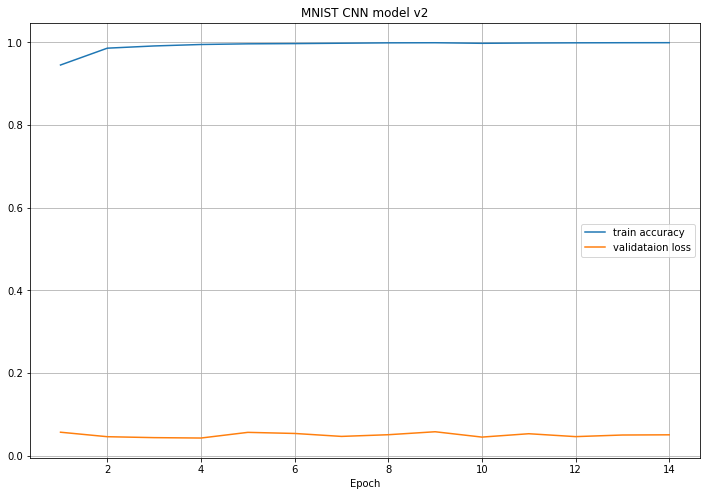

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validataion loss')
plt.legend(), plt.grid()
plt.xlabel('Epoch')
plt.title("MNIST CNN model v2")
plt.show()